In [45]:
import itertools
import numpy
import urllib,json
import pickle

RRR = RealField(100);
eps = var('eps');

#stolen from https://ask.sagemath.org/question/8390/creating-an-array-of-variables/
class VariableGenerator(object): 
     def __init__(self, prefix): 
         self.__prefix = prefix 
     @cached_method 
     def __getitem__(self, key): 
         return SR.var("%s%s"%(self.__prefix,key)) 

#object: what to dump; name: string without ".pickle"
def pickletofile(object,name):
    thefile = open(name+".pickle",'wb');
    pickle.dump(object,thefile);
    thefile.close();
    return

#filename: string without ".pickle"
def unpicklefile(filename):
    thefile = open(filename+".pickle",'rb');
    theobj = pickle.load(thefile);
    thefile.close();
    return theobj

def savewits():
    pickletofile(SC,"stoch_complexity");
    pickletofile(SW,"witnesses");
    return;

#NOTE: use dictionary NC for strings of length 2 through 10.
#expects sigma to be an array/list, like usual
def nfacomplexity(sigma):
    theurl = "http://math.hawaii.edu/~bjoern/complexity-api/?string="+''.join(str(ch) for ch in sigma);
    response = urllib.urlopen(theurl);
    data = json.loads(response.read());
    return int(data.get('complexity'))

#returns bit flip of a string (given as a tuple)
def flip(sigma):
    l = [];
    for ch in sigma:
        l.append(1-ch);
    return tuple(l)

#flips every string in an iterable, returns a Set
def flipset(strings):
    theset = [];
    for s in strings:
        theset.append(flip(s));
    return Set(theset)

#switches the order of a pair of matrices
def switchmats(matpair):
    return [matpair[1],matpair[0]]

#expects start_states & accept_states to be lists
def accprob(transmatrices,sigma,start_states=None,accept_states=None):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols() == len(accept_states);
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    if start_states == None:
        v = Matrix(Id[0]);
    else:
        v = Matrix(start_states);
    if accept_states == None:
        f = Matrix(Id[n-1]).transpose();
    else:
        f = Matrix(accept_states).transpose();
    A = v*Id;
    for ch in sigma:
        assert int(ch) == 0 or int(ch) == 1;
        A = A*transmatrices[int(ch)];
    A = A*f;
    return A[0][0];

#expects start_states & accept_states to be matrices already
def accprob_vector(transmatrices,sigma,start_states,accept_states):
    #assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols() == len(accept_states);
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    v = start_states;
    f = accept_states;
    A = v*Id;
    for ch in sigma:
        assert int(ch) == 0 or int(ch) == 1;
        A = A*transmatrices[int(ch)];
    A = A*f;
    return A[0][0];
 
def probmatrix(transmatrices,sigma):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols();
    A = identity_matrix(transmatrices[0].nrows());
    for ch in sigma:
        assert int(ch) == 0 or int(ch) == 1;
        A = A*transmatrices[int(ch)];
    return A;
    
#lengths can be either an integer or a list
def list_probs(transmatrices,start_states=None,accept_states=None,lengths=range(1,5)):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols();
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    if start_states == None:
        v = Matrix(Id[0]);
    else:
        v = Matrix(start_states);
    if accept_states == None:
        f = Matrix(Id[n-1]).transpose();
    else:
        f = Matrix(accept_states).transpose();
    if isinstance(lengths,sage.rings.integer.Integer):
        lenlist = [lengths];
    else:
        lenlist = lengths;
    
    problist = []; #list of strings with their acceptance probabilities
    for i in lenlist:
        l = list(itertools.product([0,1],repeat=i));
        for st in l:
            A = v*Id;
            for ch in st:
                assert int(ch) == 0 or int(ch) == 1;
                A = A*transmatrices[int(ch)];
            A = A*f;
            problist.append((st,A[0][0]));
        
    return problist;

#pass a list of binary strings to test, instead of a range
def list_probs_fromwords(transmatrices,start_states,accept_states,words=None):
    assert transmatrices[0].nrows() == transmatrices[0].ncols() == transmatrices[1].nrows() == transmatrices[1].ncols() == len(accept_states);
    n = transmatrices[0].nrows();
    Id = identity_matrix(n);
    v = Matrix(start_states);
    f = Matrix(accept_states).transpose();
    if words == None:
        words = list(itertools.product([0,1],repeat=11));
    
    problist = []; #list of strings with their acceptance probabilities
    for st in words:
        A = v*Id;
        for ch in st:
            assert int(ch) == 0 or int(ch) == 1;
            A = A*transmatrices[int(ch)];
        A = A*f;
        problist.append((st,A[0][0]));
        
    return problist;
    
#expects a list in exactly the format returned by list_probs. if length>0, only looks at strings of exactly that length
def highest_prob(problist,length=0):
    assert length >= 0;
    if length == 0:
        sublist = problist;
    elif length > 0:
        sublist = [l for l in problist if len(l[0]) == length];
    highprob = max([l[1] for l in sublist]);
    highstr = [st for st in sublist if st[1] == highprob];
    return highstr;
    
def sortproblist(problist):
    return sorted(problist,key=lambda x:x[1],reverse=True);
    
    
#check transition matrices for rows summing to 1
def checkmatrices(P):
    assert P[0].nrows() == P[0].ncols() == P[1].nrows() == P[1].ncols();
    n = P[0].nrows();
    
    for i in range(2):
        for j in range(n):
            s = sum(P[i][j]);
            if s != 1:
                if s > 1: relto1 = " > 1";
                elif s < 1: relto1 = " < 1";
                print "P"+str(i)+" row "+str(j+1)+" sum is "+str(RRR(s))+relto1;
                
#return list of pairs of nstates x nstates matrices
#(1/step) will be the increment of transition probabilities
#if half=True, don't include (a) both ways to order a
#pair of matrices; (b) pairs where both mats are the same.
#if info=True, print sizes of stuff along the way
def bruteforce(nstates,step,half=False,info=False):
    linit = Compositions(nstates+step,length=nstates);
    if info: print str(len(linit))+" partitions";
    lrows = [ [0]*nstates ];
    for t in linit:
        r = []; #do arithmetic on t by hand
        for i in t:
            r.append(QQ(i-1)/step);
        lrows.append(r);
    if info: print str(len(lrows))+" rows";
    mats = Tuples(lrows,nstates).list();
    if info: print str(len(mats))+" matrices";
    if not half:
        mats2 = Tuples(mats,2).list();
    else:
        mats2 = list(itertools.combinations(mats,2));
    if info: print str(len(mats2))+" matrix pairs";
    Pnew = [];
    for P in mats2:
        Pnew.append([Matrix(QQ,P[0]),Matrix(QQ,P[1])]);
    return Pnew;

#do bruteforce() algo on only a given list of vectors (as lists)
#assumes all vectors are of the same length
#does NOT check vectors sum to 1
def bruteforcevecs(vecs,half=False,info=False):
    if info: print str(len(vecs))+" rows";
    n = len(vecs[0]);
    mats = Tuples(vecs,n).list();
    if info: print str(len(mats))+" matrices";
    if not half:
        mats2 = Tuples(mats,2).list();
    else:
        mats2 = list(itertools.combinations(mats,2));
    if info: print str(len(mats2))+" matrix pairs";
    Pnew = [];
    for P in mats2:
        Pnew.append([Matrix(QQ,P[0]),Matrix(QQ,P[1])]);
    return Pnew;

#do bruteforce() algo using only the given list of transition
#probabilities as entries
#if useeps=True, the matrices will just be over SR
def bruteforceprobs(nstates,probs,half=False,info=False,useeps=False):
    for p in probs:
        if p<0 or p>1:
            probs.remove(p);
    pro = Set(probs);
    if info: print str(pro.cardinality())+" possible entries";
    lrowsall = Tuples(pro.list(),nstates).list();
    lrows = [];
    for r in lrowsall:
        s = sum(r);
        if s == 0 or s == 1: lrows.append(r);
    if info: print str(len(lrows))+" rows";
    mats = Tuples(lrows,nstates).list();
    if info: print str(len(mats))+" matrices";
    if not half:
        mats2 = Tuples(mats,2).list();
    else:
        mats2 = list(itertools.combinations(mats,2));
    if info: print str(len(mats2))+" matrix pairs";
    Pnew = [];
    if useeps:
        for P in mats2:
            Pnew.append([Matrix(P[0]),Matrix(P[1])]);
    else:
        for P in mats2:
            Pnew.append([Matrix(QQ,P[0]),Matrix(QQ,P[1])]);
    return Pnew;

#expects a list of pairs of matrices as returned by bruteforce()
#strlen = length of strings to try, accept_states = vector (list)
def finduniques(matpairs,strlen,start_states=None,accept_states=None):
    uniques = [];
    n = matpairs[0][0].nrows();
    if start_states == None:
        start_states = list(identity_matrix(n)[0]);
    if accept_states == None:
        accept_states = list(identity_matrix(n)[n-1]);
    words = list(itertools.product([0,1],repeat=strlen));
    for P in matpairs:
        probs = list_probs_fromwords(P,start_states,accept_states,words);
        high = highest_prob(probs);
        if len(high) == 1:
            uniques.append([P,high]);
    return uniques;

#updates PFA complexities and adds new witnesses to SW
#uniqlist should be in the format output by finduniques()
#ASSUMES ALL MATRICES IN uniqlist ARE OF THE SAME SIZE!!!!!
#specify the _same_ list of accept states for all of them.
#return number of new witnesses added
def addwits(uniqlist,start_states=None,accept_states=None):
    n = uniqlist[0][0][0].nrows();
    count = 0;
    if start_states == None:
        v = Matrix(identity_matrix(n)[0]);
    else:
        v = Matrix(start_states);
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
    else:
        f = Matrix(accept_states).transpose();
    for u in uniqlist:
        s = u[1][0][0];
        if not SC.has_key(s) or SC[s] > n:
            SC[s] = n;
        if SC[s] == n:
            try:
                ind = SW[s].index((u[0],v,f));
            except ValueError:
                SW[s].append((u[0],v,f));
                count = count + 1;
    return count;

#like addwits(), but only adds if there isn't a witness yet for
#each particular string
#uniqlist should be in the format output by finduniques()
#ASSUMES ALL MATRICES IN uniqlist ARE OF THE SAME SIZE!!!!!
#specify the _same_ list of accept states for all of them.
#return number of new witnesses added
def addwitsnew(uniqlist,start_states=None,accept_states=None):
    n = uniqlist[0][0][0].nrows();
    count = 0;
    for u in uniqlist:
        s = u[1][0][0];
        if len(SW[s]) > 0 and SC.has_key(s):
            continue;
        count = count + addonewit(u,s,start_states,accept_states);
    return count;

#adds thewit (a pair of matrices) as a witness for sigma to SW
#also updates SC if appropriate
#only does it if this witnesses minimal complexity
#return 0 if nothing was added or updated;
#       1 if only a new witness;
#       2 if new witness and complexity updated.
def addonewit(thewit,sigma,start_states=None,accept_states=None):
    assert len(thewit) == 2;
    n = thewit[0].nrows();
    assert n == thewit[1].nrows() == thewit[0].ncols() == thewit[1].ncols();
    ret = 0;
    if start_states == None:
        v = Matrix(identity_matrix(n)[0]);
    else:
        assert n == len(start_states);
        v = Matrix(start_states);
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
    else:
        assert n == len(accept_states);
        f = Matrix(accept_states).transpose();
    if not SC.has_key(sigma) or SC[sigma] > n:
        SC[sigma] = n;
        ret = ret + 1;
    if SC[sigma] == n:
        try:
            ind = SW[sigma].index((thewit,v,f));
        except ValueError:
            SW[sigma].append((thewit,v,f));
            ret = ret + 1;
    return ret;

#same as addonewit(), but start/accept_states should now already be a
#matrix in the correct form
def addonewit_vec(thewit,sigma,start_states,accept_states):
    n = thewit[0].nrows();
    ret = 0;
    if not SC.has_key(sigma) or SC[sigma] > n:
        SC[sigma] = n;
        ret = ret + 1;
    if SC[sigma] == n:
        try:
            ind = SW[sigma].index((thewit,start_states,accept_states));
        except ValueError:
            SW[sigma].append((thewit,start_states,accept_states));
            ret = ret + 1;
    return ret;
    

#among PFAs given by matpairs, returns the first found which
#has sigma as its highest-prob word among strings of len(sigma).
#assumes all matrices have the same size.
#if stop>0, find the first stop witnesses (if possible).
#if stop=0, find all witnesses, if possible.
def findwitness(matpairs,sigma,start_states=None,accept_states=None,stop=1):
    n = matpairs[0][0].nrows();
    if start_states == None:
        v = Matrix(identity_matrix(n)[0]);
    else:
        v = Matrix(start_states);
    if accept_states == None:
        f = matrix(identity_matrix(n)[n-1]).transpose();
    else:
        f = matrix(accept_states).transpose();
    words = list(itertools.product([0,1],repeat=len(sigma)));
    words.remove(sigma);
    
    found = 0;
    wits = [];
    for P in matpairs:
        sigprob = accprob_vector(P,sigma,v,f);
        if sigprob == 0:
            continue;
        iscandidate = True;
        for s in words:
            testprob = accprob_vector(P,s,v,f);
            if testprob >= sigprob:
                iscandidate = False;
                break;
        if iscandidate:
            if stop != 1:
                wits.append((P,v,f));
            elif stop == 1:
                return P; #the traditional behavior
            found = found + 1;
            if stop > 0 and found >= stop:
                return wits;
    if len(wits) == 0:
        return None;
    else:
        return wits;

#expects a list in the format given by finduniques
#sigma should be a TUPLE, not an array! (?)
#returns the first pair of matrices in uniqlist witnessing the
#PFA complexity of sigma
def firstwitness(uniqlist,sigma):
    return [u[0] for u in uniqlist if u[1][0][0] == sigma][0]

#expects a dictionary like SC or NC
#returns Set of keys in compdict with value=complexity
#restricts to length strlen if strlen>0; o/w no restr on length
#if less=True, returns keys with value<=complexity
def lookup(compdict,complexity,strlen=0,less=False):
    if strlen == 0 and not less:
        return Set([k for k in compdict.keys() if compdict[k] == complexity]);
    elif strlen > 0 and not less:
        return Set([k for k in compdict.keys() if compdict[k] == complexity and len(k) == strlen]);
    elif strlen == 0 and less:
        return Set([k for k in compdict.keys() if compdict[k] <= complexity]);
    elif strlen > 0 and less:
        return Set([k for k in compdict.keys() if compdict[k] <= complexity and len(k) == strlen]);


#return largest denominator in a pair of rational matrices
def matdenom(matpair):
    themax = 1;
    for i in range(2):
        for r in matpair[i]: #rows
            for e in r: #element
                d = QQ(e).denominator();
                themax = lcm(d,themax);
    return themax;

#return first witness for PFA complexity of sigma in SW with
#matdenom <= denom
def firstwitdenom(sigma,denom):
    if not SW.has_key(sigma) or len(SW[sigma]) == 0:
        return None;
    for mats in SW[sigma]:
        if matdenom(mats[0]) <= denom:
            return mats;
    return None;

#return list of witnesses for PFA complexity of sigma in SW
#with matdenom = denom
def witsdenom(sigma,denom):
    if not SW.has_key(sigma) or len(SW[sigma]) == 0:
        return None;
    thelist = [];
    for mats in SW[sigma]:
        if matdenom(mats[0]) == denom:
            thelist.append(mats);
    if thelist == []:
        return None;
    return thelist;

#return lowest denominator out of all witnesses for sigma in SW
def mindenom(sigma):
    if not SW.has_key(sigma) or len(SW[sigma]) == 0:
        return None;
    return min([matdenom(w[0]) for w in SW[sigma]]);

#return highest denominator out of all witnesses for sigma in SW
def maxdenom(sigma):
    if not SW.has_key(sigma) or len(SW[sigma]) == 0:
        return None;
    return max([matdenom(w[0]) for w in SW[sigma]]);

#determine if matpair represents an actual aut (as in Rabin)
def isactualaut(matpair):
    for i in range(2):
        for r in matpair[i]: #rows
            for e in r: #entries
                if e == 0:
                    return False;
    return True;

#substitute epses (tuple of epsilons, one tuple per matrix,
#one epsilon per row) into matpairs for the variable eps
def matsub(matpairs,epses):
    assert len(epses[0]) == len(epses[1]) == matpairs[0].nrows();
    newmat = [ [], [] ];
    for i in range(2):
        for e in range(len(epses[i])):
            newmat[i].append(matpairs[i][e].substitute(eps=epses[i][e]));
    return [Matrix(QQ,newmat[0]), Matrix(QQ,newmat[1])];

#just returns the digraph of the aut described by matpair
def autgraph(matpair):
    n = matpair[0].nrows();
    gr = DiGraph(n,loops=True,multiedges=True);
    for l in range(2): #letter seen
        for i in range(n): #transition from state i...
            for j in range(n): #to state j
                if matpair[l][i][j] > 0:
                    gr.add_edge(i,j,label=str(l)+" ("+str(matpair[l][i][j])+")");
    return gr;

#plots the specified aut from SW
#its=# of iterations for plotting algo
def autplotwit(sigma,ind,its=2):
    matpair = SW[sigma][ind][0];
    f = SW[sigma][ind][1];
    n = f.nrows();
    gr = autgraph(matpair);
    acc = [i for i in range(n) if f[i][0] == 1];
    notacc = Set(range(n)).difference(Set(acc)).list();
    return gr.plot(edge_labels=True,vertex_size=400,layout='spring',iterations=its,vertex_colors={'white': notacc,'yellow': acc});

#expects a matrix pair defining the automaton
def autplot(matpair,accept_states=None,its=2):
    n = matpair[0].nrows();
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
        acc = [n-1];
    else:
        f = Matrix(accept_states).transpose();
        acc = [i for i in range(n) if accept_states[i] == 1];
    gr = autgraph(matpair);
    notacc = Set(range(n)).difference(Set(acc)).list();
    return gr.plot(edge_labels=True,vertex_size=400,layout='spring',iterations=its,vertex_colors={'white': notacc,'yellow': acc});

#expects a digraph (probably the output of autgraph())
def autgraphplot(autg,accept_states=None,its=2):
    n = autg.order();
    if accept_states == None:
        f = Matrix(identity_matrix(n)[n-1]).transpose();
        acc = [n-1];
    else:
        f = Matrix(accept_states).transpose();
        acc = [i for i in range(n) if accept_states[i] == 1];
    notacc = Set(range(n)).difference(Set(acc)).list();
    return autg.plot(edge_labels=True,vertex_size=400,layout='spring',iterations=its,vertex_colors={'white': notacc,'yellow': acc});

In [2]:
#run immediately when restarting
SC = unpicklefile("stoch_complexity");
NC = unpicklefile("nfa_complexity");
SW = unpicklefile("witnesses");

In [3]:
#STATS
print len(SC)
for l in range(3,11):
    if l<9:
        top=4;
    else:
        top=5;
    for c in range(1,top):
        print "len "+str(l)+" complexity "+str(c)+": "+str(lookup(SC,c,l).cardinality())+" (NFA: "+str(lookup(NC,c,l).cardinality())+")"
    nu = lookup(SC,100,l,less=True).cardinality();
    if nu < 2^l:
        print "total classified "+str(nu)+"/"+str(2^l);
    witsum = sum([len(SW[k]) for k in SW.keys() if len(k)==l]);
    print "total witnesses "+str(witsum);
    print ""
print "# strings of each length with PFA=NFA complexity:"
for l in range(3,11):
    print str(l)+": "+str(len([k for k in SC.keys() if len(k) == l and SC[k] == NC[k]]))

1119
len 3 complexity 1: 2 (NFA: 2)
len 3 complexity 2: 6 (NFA: 6)
len 3 complexity 3: 0 (NFA: 0)
total witnesses 6

len 4 complexity 1: 2 (NFA: 2)
len 4 complexity 2: 14 (NFA: 6)
len 4 complexity 3: 0 (NFA: 8)
total witnesses 410

len 5 complexity 1: 2 (NFA: 2)
len 5 complexity 2: 20 (NFA: 6)
len 5 complexity 3: 10 (NFA: 24)
total witnesses 354

len 6 complexity 1: 2 (NFA: 2)
len 6 complexity 2: 28 (NFA: 6)
len 6 complexity 3: 34 (NFA: 26)
total witnesses 658

len 7 complexity 1: 2 (NFA: 2)
len 7 complexity 2: 32 (NFA: 6)
len 7 complexity 3: 94 (NFA: 22)
total witnesses 182

len 8 complexity 1: 2 (NFA: 2)
len 8 complexity 2: 40 (NFA: 6)
len 8 complexity 3: 214 (NFA: 20)
total witnesses 756

len 9 complexity 1: 2 (NFA: 2)
len 9 complexity 2: 44 (NFA: 6)
len 9 complexity 3: 370 (NFA: 20)
len 9 complexity 4: 0 (NFA: 78)
total classified 416/512
total witnesses 790

len 10 complexity 1: 2 (NFA: 2)
len 10 complexity 2: 24 (NFA: 6)
len 10 complexity 3: 143 (NFA: 20)
len 10 complexity 4: 6 (

In [3]:
test2x2 = bruteforce(2,2);
test2x3 = bruteforce(2,3);
test2x4 = bruteforce(2,4);
test2x5 = bruteforce(2,5);
test2x6 = bruteforce(2,6);
test2x7 = bruteforce(2,7);
test2x8 = bruteforce(2,8);
test3x2 = bruteforce(3,2);

somevecs = [ [1,0,0],[0,1,0],[0,0,1],[0,0,0],[1/4,1/4,1/2],
           [1/4,1/2,1/4],[1/2,1/4,1/4]];
some3x4 = bruteforcevecs(somevecs,half=True);

S = {};
for i in range(2,12):
    S[i] = Set(itertools.product([0,1],repeat=i));

In [ ]:
half3x3 = bruteforce(3,3,half=True);
print len(half3x3);
test2x10 = unpicklefile("test2x10");
print len(test2x10);
test2x15 = unpicklefile("test2x15");
print len(test2x15);
test2x20 = unpicklefile("test2x20");
print len(test2x20);
#test4x1 = unpicklefile("test4x1");
#test3x4 = unpicklefile("test3x4");

In [ ]:
test3x3 = unpicklefile("test3x3");
print len(test3x3);
test2x29 = unpicklefile("test2x29");
print len(test2x29);
test2x36 = unpicklefile("test2x36");
print len(test2x36);

In [ ]:
#correctness check
c = 0;
for k in SW.keys():
    for W in SW[k]:
        sys.stdout.write(str(k)+"   %d\r" % (c) );
        #sys.stdout.flush();
        c = c + 1;
        if SC.has_key(k) and W[0][0].nrows() > SC[k]:
            print "mat size > SC",k,W;
            print "";
            SW[k].remove(W);
            continue;
        if findwitness([W[0]],k,W[1].list(),W[2].list()) == None:
            print k,W;
            print "";
            SW[k].remove(W);

In [35]:
for k in SC.keys():
    if NC.has_key(k) == False:
        continue;
    if SC[k] > NC[k]:# and 4<len(k)<8:
        print k,SC[k],NC[k];

In [8]:
#make sure the bitflip of every string also has a witness
for s in S[9]:
    if len(SW[s])>0 and len(SW[flip(s)])==0:
        m = SW[s][0][0];
        v = SW[s][0][1];
        f = SW[s][0][2];
        print flip(s),addonewit_vec(switchmats(m),flip(s),v,f);

In [127]:
notmatching = [s for s in SC.keys() if SC.has_key(flip(s))==True and SC[s] > SC[flip(s)]];
print len(notmatching)

0


In [15]:
for s in notmatching:
    print s,SC[s],flip(s),SC[flip(s)]

In [16]:
#to fix witnesses for notmatching (ONLY RUN ONCE!)
for s in notmatching:
    print s;
    SW[s] = [];
    m = SW[flip(s)][0][0];
    v = SW[flip(s)][0][1];
    f = SW[flip(s)][0][2];
    print addonewit_vec(switchmats(m),s,v,f)

In [188]:
c = 0;
#for s in lookup(SC,3,5):
for s in lookup(SC,4):
#for s in notmatching:
#for s in lookup(SC,3,8):
#for s in singles:
    #if len(SW[s]) > 0:# or mindenom(s) > 2:
    #    continue;
    if len(s) < 5 or SC[s] == 2:
        continue;
    c = c + 1;
    if c < 0:
        continue;
    if c > 50:
        break;
    sys.stdout.write("%d\r" % (c) );
    v = [1/2,1/2];
    f = [0,1];
    #f = list(reversed(f));
    wits = findwitness(test2x6[::],s,v,f);
    if wits != None:
        print s,wits,addonewit(wits,s,v,f);
        print "";
        print flip(s),switchmats(wits),addonewit(switchmats(wits),flip(s),v,f);
        print "";

In [171]:
savewits()

In [ ]:
#really inefficient (for larger sets of strings)
c = 0;
for s in S[9].difference(lookup(SC,2,9,less=True)):
    if len(SW[s]) > 0:
        continue;
    c = c + 1;
    if c < 0:
        continue;
    if c > 50:
        break;
    sys.stdout.write("%d\r" % (c) );
    v = [1,0,0];
    f = [0,0,1];
    #wits = findwitness(test3x2[1::100],s,f);
    wits = findwitness(test3x3[269500:450000:91],s,v,f);
    #wits = findwitness(test2x15[::13],s,f);
    if wits != None:
        print s,wits,addonewit(wits,s,v,f);
        print "";
        print flip(s),switchmats(wits),addonewit(switchmats(wits),flip(s),v,f);
        print "";

In [154]:
epses = [1/100,1/1000,1/10000];
probs = [0];
for e in epses:
    for d in [1,2]:
        f5 = 1/d-e;
        f6 = 1/d+e;
        probs.append(f5);
        probs.append(f6);
        probs.append(1-f5);
        probs.append(1-f6);
print probs,len(probs)
test1 = bruteforceprobs(2,probs,half=False,info=True)
#test1 = bruteforceprobs(2,[eps1,1-eps1,1/2-eps1,1/2+eps1,eps1/10,1-eps1/10],half=True,info=True)

[0, 99/100, 101/100, 1/100, -1/100, 49/100, 51/100, 51/100, 49/100, 999/1000, 1001/1000, 1/1000, -1/1000, 499/1000, 501/1000, 501/1000, 499/1000, 9999/10000, 10001/10000, 1/10000, -1/10000, 4999/10000, 5001/10000, 5001/10000, 4999/10000] 25
13 possible entries
13 rows
169 matrices
28561 matrix pairs


In [155]:
epses1a = [0,1/100,1/1000,1/10000,1/100000];
probs1a = [0];
for e in epses1a:
    for d in [1,2]:
        f5 = 1/d-e;
        f6 = 1/d+e;
        probs1a.append(f5);
        probs1a.append(f6);
        probs1a.append(1-f5);
        probs1a.append(1-f6);
print probs1a,len(probs1a)
test1a = bruteforceprobs(2,probs1a,half=True,info=True)

[0, 1, 1, 0, 0, 1/2, 1/2, 1/2, 1/2, 99/100, 101/100, 1/100, -1/100, 49/100, 51/100, 51/100, 49/100, 999/1000, 1001/1000, 1/1000, -1/1000, 499/1000, 501/1000, 501/1000, 499/1000, 9999/10000, 10001/10000, 1/10000, -1/10000, 4999/10000, 5001/10000, 5001/10000, 4999/10000, 99999/100000, 100001/100000, 1/100000, -1/100000, 49999/100000, 50001/100000, 50001/100000, 49999/100000] 41
19 possible entries
20 rows
400 matrices
79800 matrix pairs


In [27]:
test2 = bruteforceprobs(4,[1/100,97/100,0],half=True,info=True)

3 possible entries
5 rows
625 matrices
195000 matrix pairs


In [6]:
test3=bruteforceprobs(3,[1/4,3/8,5/8,0],half=True,info=True)

4 possible entries
10 rows
1000 matrices
499500 matrix pairs


In [157]:
eps1=1/1000
test4=bruteforceprobs(2,[eps1,1-eps1,1/2-eps1,1/2+eps1,1/3-eps1,2/3+eps1,1/3+eps1,2/3-eps1,1/4-eps1,3/4+eps1,1/4+eps1,3/4-eps1,0],half=True,info=True)

13 possible entries
13 rows
169 matrices
14196 matrix pairs


In [156]:
v2 = [1/2,1/2];
f2 = [0,1];
#f2 = list(reversed(f2));
#uniq2 = finduniques(test2x5,5,v2,f2);
uniq2 = finduniques(test1a[1::10],5,v2,f2);
#uniq2 = finduniques(test2[11000:12000:],10,v2,f2);
#uniq2 = finduniques(test3[301000:302000:13],10,v2,f2);
#uniq2 = finduniques(test4[12500:13000:],10,v2,f2);
print len(uniq2)
for s in Set([u[1][0][0] for u in uniq2]):
    if SC.has_key(s):
        print s,SC[s],NC[s];
    else:
        print s,"n/a",NC[s];

7391
(1, 1, 1, 0, 0) 2 3
(1, 1, 0, 1, 0) 2 3
(1, 1, 1, 1, 0) 2 2
(1, 1, 1, 0, 1) 2 3
(1, 0, 1, 0, 1) 2 2
(1, 0, 0, 0, 0) 2 2
(0, 0, 1, 1, 1) 2 3
(0, 0, 0, 0, 1) 2 2
(0, 0, 0, 1, 0) 2 3
(1, 1, 0, 0, 0) 2 3
(0, 0, 0, 0, 0) 1 1
(0, 0, 1, 0, 1) 2 3
(0, 0, 0, 1, 1) 2 3
(0, 1, 1, 1, 0) 2 3
(0, 1, 0, 1, 0) 2 2
(1, 0, 0, 0, 1) 2 3
(1, 1, 1, 1, 1) 1 1
(0, 1, 1, 1, 1) 2 2


In [39]:
#only bother adding witnesses if we don't already have one
#c = 0;
for u in uniq2:
    s = u[1][0][0];
    #don't bother if NC is lower, either
    if NC.has_key(s) and NC[s] < u[0][0].nrows(): continue;
    if not SW.has_key(s) or not SC.has_key(s) or SC[s] > u[0][0].nrows() or len(SW[s]) == 0:
        a = addonewit(u[0],s,v2,f2);
        if a > 0:
            #c = c + a;
            print s,SC[s],a;
#print c

In [22]:
savewits()

In [22]:
#0011 witness test
W1 = [Matrix([[1/2+eps,1/2-eps],[1/2-eps,1/2+eps]]), 
      Matrix([[1-eps,eps],[eps,1-eps]])];
epses1 = [[.01,.01],[10^(-10),10^(-11)]];
W1sub = matsub(W1,epses1);
W1list = list_probs(W1sub,[1,0],[0,1],range(4,16));
print highest_prob(W1list,4)
#print ""
#print sortproblist(W1list)

[((0, 0, 0, 0), 6249999/12500000)]


In [23]:
for i in range(4,16):
    hi = highest_prob(W1list,i);
    print len(hi),hi[0][0]

1 (0, 0, 0, 0)
1 (0, 0, 0, 0, 0)
1 (0, 0, 0, 0, 0, 0)
1 (0, 0, 0, 0, 0, 0, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1)
1 (0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)


In [26]:
print .5^6, RR(10^(-10))

0.0156250000000000 1.00000000000000e-10


In [177]:
#0011 test2
W12 = [Matrix(QQ,[[0,1],[1,0]]), 
       Matrix(QQ,[[1,0],[0,0]])];
W12list = list_probs(W12,[1,0],[1,0],4);
print highest_prob(W12list)
print accprob(W12,(0,0,1,1),(1,0),(1,0))

[((0, 0, 0, 0), 1), ((0, 0, 1, 1), 1), ((1, 0, 0, 1), 1), ((1, 1, 0, 0), 1), ((1, 1, 1, 1), 1)]
1


In [44]:
a1,b1,c1,d1,a2,b2,c2,d2=var('a1,b1,c1,d1,a2,b2,c2,d2')
W12a = [Matrix([[a1,b1],[c1,d1]]),
        Matrix([[a2,b2],[c2,d2]])];

In [42]:
for s in [(0,),(0,0),(0,0,1),(0,0,1,1),(0,0,1,1,1),
          (0,0,1,1,1,1),(0,0,1,1,1,1,1)]:
    print s
    pretty_print(accprob(W12a,s,(1,0),(0,1)))
    print ""

(0,)


b1


(0, 0)


a1*b1 + b1*d1


(0, 0, 1)


(a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2


(0, 0, 1, 1)


((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2


(0, 0, 1, 1, 1)


(((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*b2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*d2


(0, 0, 1, 1, 1, 1)


((((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*a2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*c2)*b2 + ((((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*b2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*d2)*d2


(0, 0, 1, 1, 1, 1, 1)


(((((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*a2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*c2)*a2 + ((((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*b2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*d2)*c2)*b2 + (((((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*a2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*c2)*b2 + ((((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*a2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*c2)*b2 + (((a1^2 + b1*c1)*a2 + (a1*b1 + b1*d1)*c2)*b2 + ((a1^2 + b1*c1)*b2 + (a1*b1 + b1*d1)*d2)*d2)*d2)*d2)*d2

In [41]:
for s in [(0,),(0,0),(0,0,0),(0,0,0,0),(0,0,0,1),(0,0,0,1,1),
          (0,0,0,1,1,1),(0,0,0,1,1,1,1)]:
    print s
    pretty_print(accprob(W12a,s,(1,0),(0,1)))
    print ""

(0,)


b1


(0, 0)


a1*b1 + b1*d1


(0, 0, 0)


(a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1


(0, 0, 0, 0)


((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b1 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d1


(0, 0, 0, 1)


((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2


(0, 0, 0, 1, 1)


(((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*b2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*d2


(0, 0, 0, 1, 1, 1)


((((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*a2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*c2)*b2 + ((((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*b2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*d2)*d2


(0, 0, 0, 1, 1, 1, 1)


(((((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*a2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*c2)*a2 + ((((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*b2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*d2)*c2)*b2 + (((((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*a2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*c2)*b2 + ((((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*a2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*c2)*b2 + (((a1^2 + b1*c1)*a1 + (a1*b1 + b1*d1)*c1)*b2 + ((a1^2 + b1*c1)*b1 + (a1*b1 + b1*d1)*d1)*d2)*d2)*d2)*d2

In [47]:
a0 = VariableGenerator('a0')
b0 = VariableGenerator('b0')
c0 = VariableGenerator('c0')
d0 = VariableGenerator('d0')
a1 = VariableGenerator('a1')
b1 = VariableGenerator('b1')
c1 = VariableGenerator('c1')
d1 = VariableGenerator('d1')

In [59]:
#idea: {a,b,c,d}_ij = prob seeing i on the jth symbol
#(so, ofc, each is the same value for all j)
P0 = [];
P1 = [];
for i in range(16):
    P0.append(Matrix([[a0[i],b0[i]],[c0[i],d0[i]]]))
    P1.append(Matrix([[a1[i],b1[i]],[c1[i],d1[i]]]))

In [61]:
A = identity_matrix(2);
for i in range(7):
    if i <= 2: #start with (bound+1) zeros
        A = A*P0[i];
    else:
        A = A*P1[i];
pretty_print(A[0][1]) #upper right entry

(((((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*a13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*c13)*a14 + (((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*b13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*d13)*c14)*a15 + ((((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*a13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*c13)*b14 + (((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*b13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*d13)*d14)*c15)*b16 + (((((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*a13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*c13)*a14 + (((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*b13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*d13)*c14)*b15 + ((((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*a13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*c13)*b14 + (((a00*a01 + b00*c01)*a02 + (a00*b01 + b00*d01)*c02)*b13 + ((a00*a01 + b00*c01)*b02 + (a00*b01 + b00*d01)*d02)*d13)*d14)*d15)*d16

In [178]:
#0110 witness (W3)
W3 = [Matrix(QQ,[[0,1],[1/2,1/2]]),Matrix(QQ,[[0,0],[0,1]])];
highest_prob(list_probs(W3,(1,0),(1,0),8))

[((0, 1, 1, 1, 1, 1, 1, 0), 1/2)]

In [72]:
#playing with 0010 witness
W4 = [Matrix([[eps,1-eps],[1/2+eps,1/2-eps]]), 
     Matrix([[1/2-eps,1/2+eps],[1/2-eps,1/2+eps]])];
epses2 = [.01,.001,.0001]; #values to build from
epspairs = Tuples(epses2,2).list();
epsmats = Tuples(epspairs,2).list();
W4subs = [];
for e in epsmats:
    W4subs.append(matsub(W4,e));
uniqW4 = finduniques(W4subs,4,[1,0],[0,1]);
print len(uniqW4)
print Set([u[1][0][0] for u in uniqW4])

60
{(1, 0, 1, 0), (1, 1, 1, 0), (0, 0, 1, 0)}


In [ ]:
for u in uniqW4:
    if u[1][0][0]==(0,0,1,0):
        print u
        print matdenom(u[0])
        print ""

In [180]:
#010011 tests
W51 = [Matrix(QQ,[[0,1,0],[0,0,0],[1/4,0,3/4]]),
       Matrix(QQ,[[0,0,0],[0,1/4,3/4],[0,1/2,1/2]])];
W51list = list_probs(W51,(1,0,0),(0,0,1),6);
print highest_prob(W51list)
print ""
print accprob(W51,(0,1,0,0,1,1),(1,0,0),(0,0,1))
print sortproblist(W51list)

[((0, 1, 1, 1, 1, 1), 615/1024)]

189/512
[((0, 1, 1, 1, 1, 1), 615/1024), ((0, 1, 1, 1, 1, 0), 459/1024), ((0, 1, 0, 0, 1, 1), 189/512), ((0, 1, 1, 1, 0, 0), 351/1024), ((0, 1, 0, 1, 1, 1), 171/512), ((0, 1, 0, 0, 0, 1), 135/512), ((0, 1, 0, 0, 1, 0), 135/512), ((0, 1, 0, 1, 1, 0), 135/512), ((0, 1, 1, 0, 0, 1), 135/512), ((0, 1, 1, 0, 1, 1), 135/512), ((0, 1, 0, 0, 0, 0), 243/1024), ((0, 1, 1, 0, 0, 0), 243/1024), ((0, 1, 1, 1, 0, 1), 117/512), ((0, 1, 0, 1, 0, 0), 81/512), ((0, 1, 1, 0, 1, 0), 81/512), ((0, 1, 0, 1, 0, 1), 27/256), ((0, 0, 0, 0, 0, 0), 0), ((0, 0, 0, 0, 0, 1), 0), ((0, 0, 0, 0, 1, 0), 0), ((0, 0, 0, 0, 1, 1), 0), ((0, 0, 0, 1, 0, 0), 0), ((0, 0, 0, 1, 0, 1), 0), ((0, 0, 0, 1, 1, 0), 0), ((0, 0, 0, 1, 1, 1), 0), ((0, 0, 1, 0, 0, 0), 0), ((0, 0, 1, 0, 0, 1), 0), ((0, 0, 1, 0, 1, 0), 0), ((0, 0, 1, 0, 1, 1), 0), ((0, 0, 1, 1, 0, 0), 0), ((0, 0, 1, 1, 0, 1), 0), ((0, 0, 1, 1, 1, 0), 0), ((0, 0, 1, 1, 1, 1), 0), ((1, 0, 0, 0, 0, 0), 0), ((1, 0, 0, 0, 0, 1), 0), ((1, 0, 0

[([[  0   1   0]
[  0   0   0]
[1/2   0 1/2], [1/2 1/2   0]
[  0 1/2 1/2]
[  0   0   0]], [0]
[0]
[1]), ([[  0   0   1]
[1/2 1/2   0]
[  0   0   0], [1/2   0 1/2]
[  0   0   0]
[  0 1/2 1/2]], [0]
[1]
[0])]


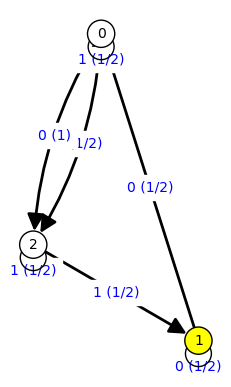

In [127]:
print SW[(0,1,0,0,1,1)]
autplotwit((0,1,0,0,1,1),1)

In [183]:
witW5 = findwitness(test3x2,(0,1,0,0,1,1),(1/2,1/2,0),(0,1,1),stop=1)
print witW5

[[1/2 1/2   0]
[  0 1/2 1/2]
[  0   0   0], [0 0 1]
[1 0 0]
[0 0 0]]


In [185]:
witW52 = findwitness(test2x8,(0,1,0,0,1,1),(1/2,1/2),(1,0))
print witW52

None


In [ ]:
for P in witW5:
    autplot(P[0],P[1].list(),its=4).show()
    print ""

In [201]:
sig=(0,1,1,1);
f3=[0,1];
wit1 = findwitness(test1[::],sig,f3,stop=5)
print len(wit1)
for w in wit1:
    print w[0]
    print ""

5
[[5001/10000 4999/10000]
[         0          0], [     0      0]
[ 1/100 99/100]]

[[  49/100   51/100]
[999/1000   1/1000], [     0      0]
[ 1/100 99/100]]

[[4999/10000 5001/10000]
[    51/100     49/100], [99/100  1/100]
[ 1/100 99/100]]

[[499/1000 501/1000]
[  51/100   49/100], [99/100  1/100]
[ 1/100 99/100]]

[[501/1000 499/1000]
[501/1000 499/1000], [99/100  1/100]
[ 1/100 99/100]]



In [33]:
savewits()

In [123]:
test5 = bruteforceprobs(2,[eps,1-eps,1/2+eps,1/2-eps,0],half=True,info=True,useeps=True)

5 possible entries
5 rows
25 matrices
300 matrix pairs


In [124]:
epses3 = [[.01,.01],[.01,.01]];
test5sub = [];
for P in test5:
    test5sub.append(matsub(P,epses3));
uniq5 = finduniques(test5sub,4,[1,0],[1,1]);
print len(uniq5)
print Set([u[1][0][0] for u in uniq5])

99
{(0, 1, 1, 1), (0, 0, 0, 0), (1, 1, 1, 1), (0, 1, 0, 1)}


In [90]:
uniq5a = finduniques(test5sub,4,[1,0]);
print len(uniq5a)
print Set([u[1][0][0] for u in uniq5a])

216
{(1, 1, 1, 0), (0, 0, 0, 0), (1, 0, 1, 0), (0, 1, 1, 1), (0, 1, 0, 1), (1, 1, 1, 1), (1, 0, 0, 1), (0, 1, 1, 0), (0, 0, 1, 1), (0, 0, 0, 1)}


In [ ]:
for u in uniq5a:
    if u[1][0][0]==(0,1,1,0):
        print u
        print matdenom(u[0])
        print ""

In [166]:
W21 = [Matrix(QQ,[[0,1],[2/3,1/3]]), Matrix(QQ,[[0,0],[1/3,2/3]])];
sortproblist(list_probs(W21,startfrom=4,upto=5,accept_states=(0,1)))

[((0, 1, 0, 0), 17/27),
 ((0, 0, 0, 1), 14/27),
 ((0, 0, 0, 0), 13/27),
 ((0, 1, 0, 1), 10/27),
 ((0, 1, 1, 0), 10/27),
 ((0, 1, 1, 1), 8/27),
 ((0, 0, 1, 0), 5/27),
 ((0, 0, 1, 1), 4/27),
 ((1, 0, 0, 0), 0),
 ((1, 0, 0, 1), 0),
 ((1, 0, 1, 0), 0),
 ((1, 0, 1, 1), 0),
 ((1, 1, 0, 0), 0),
 ((1, 1, 0, 1), 0),
 ((1, 1, 1, 0), 0),
 ((1, 1, 1, 1), 0)]

In [165]:
2/3*2/3 + 2/3*1/9 + 1/3*1/3

17/27

In [228]:
#concatenation tests
#0110^0110 (W3^W3)
W3W3 = [Matrix(QQ,[[0,1,0,0],[0,1/2,1/2,0],
                   [0,0,0,1],[0,0,1/2,1/2]]),
        Matrix(QQ,[[0,0,0,0],[0,1,0,0],
                   [0,0,0,0],[0,0,0,1]])];
highest_prob(list_probs(W3W3,accept_states=(0,0,1,0),lengths=8))

[((0, 1, 1, 1, 1, 1, 1, 0), 1/2)]

In [227]:
SW[(0,1,1,0,0,1,1,0)]

[(
[[  0   0   1]                            
[  0 1/2 1/2]                             
[  1   0   0], [  0 1/2 1/2]           [0]
[  1   0   0]                          [0]
[1/2 1/2   0]]              , [1 0 0], [1]
),
 (
[[  0   1   0]                            
[  1   0   0]                             
[1/2 1/2   0], [  0   0   1]           [0]
[1/2   0 1/2]                          [1]
[  1   0   0]]              , [1 0 0], [0]
),
 (
[[1/2   0 1/2]                      
[  1   0   0]                       
[  0   0   0], [0 0 1]           [1]
[1 0 0]                          [0]
[0 1 0]]              , [1 0 0], [0]
)]

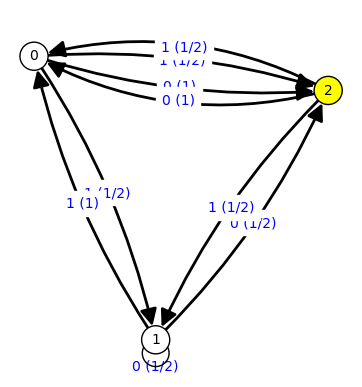

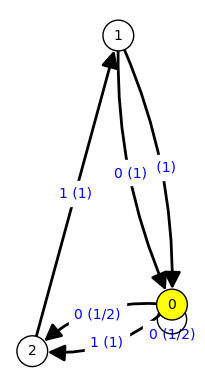

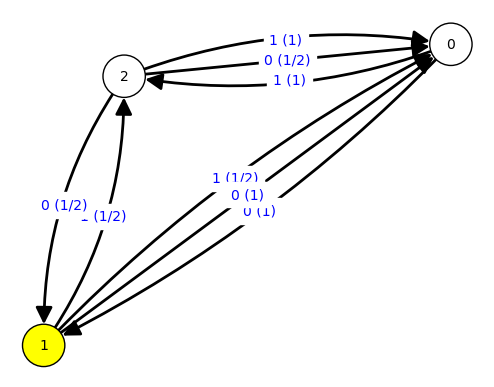

In [32]:
for i in range(len(SW[(0,1,1,0,0,1,1,0)])):
    autplotwit((0,1,1,0,0,1,1,0),i,its=5).show();
    print ""

In [226]:
somevecs2 = [[0,0,0,0],[0,1,0,0],[0,0,0,1],[0,1/2,1/2,0],
            [0,0,1/2,1/2]];
some4x2 = bruteforcevecs(somevecs2,half=True,info=True)

5 rows
625 matrices
195000 matrix pairs


In [ ]:
witW3W31 = findwitness(some4x2,sigma=(0,1,1,0,0,1,1,0),accept_states=(0,0,1,0));
print witW3W31

In [8]:
NC[(0,1,1,0,0,1,1,0)]

4

In [23]:
witw3w3 = findwitness(test3x2,sigma=(0,1,1,0,0,1,1,0),accept_states=(0,1,0),stop=10);
print witw3w3#,addonewit(thewit=witw3w3,accept_states=(0,1,0),sigma=(0,1,1,0,0,1,1,0))

[([[1/2 1/2   0]
[  1   0   0]
[1/2 1/2   0], [  0 1/2 1/2]
[  1   0   0]
[  1   0   0]], [0]
[1]
[0]), ([[1/2 1/2   0]
[  1   0   0]
[1/2 1/2   0], [  0 1/2 1/2]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[  0   1   0]
[  1   0   0]
[1/2 1/2   0], [  0 1/2 1/2]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[  0   1   0]
[1/2 1/2   0]
[1/2 1/2   0], [  0 1/2 1/2]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[  0   1   0]
[  1   0   0]
[1/2   0 1/2], [  0 1/2 1/2]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[  0   1   0]
[  1   0   0]
[  0 1/2 1/2], [  0 1/2 1/2]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[  0   1   0]
[  1   0   0]
[1/2 1/2   0], [  0   0   1]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[  0   1   0]
[1/2 1/2   0]
[1/2 1/2   0], [  0   0   1]
[1/2   0 1/2]
[  1   0   0]], [0]
[1]
[0]), ([[1/2 1/2   0]
[  1   0   0]
[1/2 1/2   0], [  0 1/2 1/2]
[  1   0   0]
[1/2   0 1/2]], [0]
[1]
[0]), ([[1/2 1/2   0]
[1/2   0 1/2]
[  0   1   0], [  0   1   0]
[1/2   0 1/2]

In [25]:
addonewit_vec(witw3w3[6][0],sigma=(0,1,1,0,0,1,1,0),accept_states=witw3w3[6][1])

1

In [55]:
for s in lookup(SC,3):
    strs = "";
    for i in range(len(s)):
        strs = strs + str(s[i]);
    for t in lookup(SC,2):
        if len(s)>=len(t): continue;
        strt = "";
        for i in range(len(t)):
            strt = strt + str(t[i]);
        if strt.startswith(strs):# and SC[t]>SC[s]:
            print s,SC[s],t,SC[t]

In [5]:
t = (0,1,1,0,1);
for s in S[8]:
    if bytearray(t) in bytearray(s) and SC[s] != SC[t]:
        print s,SC[s]

In [82]:
for s in S[5].union(S[6]):
    revs = tuple(reversed(s));
    if s[0] == 1: continue;
    if not SC.has_key(revs): continue;
    if SC[s] < SC[revs]:
        print s,SC[s],revs,SC[revs];

(0, 0, 0, 1, 1, 0) 2 (0, 1, 1, 0, 0, 0) 3
(0, 0, 1, 1, 1, 0) 2 (0, 1, 1, 1, 0, 0) 3
(0, 0, 1, 1, 0) 2 (0, 1, 1, 0, 0) 3
(0, 1, 0, 0, 0, 1) 2 (1, 0, 0, 0, 1, 0) 3
(0, 0, 1, 0, 1, 0) 2 (0, 1, 0, 1, 0, 0) 3
(0, 0, 1, 0, 1) 2 (1, 0, 1, 0, 0) 3
(0, 0, 0, 1, 0, 1) 2 (1, 0, 1, 0, 0, 0) 3


In [88]:
t = (0,0,1,0,1);
testw = SW[t][0];
print testw
tmat = probmatrix(testw[0],t);
print testw[1]*tmat

([[2/5 3/5]
[3/5 2/5], [1/5 4/5]
[  1   0]], [1 0], [1]
[0])
[1917/3125 1208/3125]


In [93]:
#revstart = [1917/3125,1208/3125];
#revend = [1,0];
revmats = [testw[0][0].transpose(),testw[0][1].transpose()];
print revstart
print revmats
#revmats aren't matrices fitting our definition!
#it "works" in the sense that it does witness the same # states for
#the reversed string. But it doesn't seem to easily lead to a
#witness that is actually valid.
#I guess it does work as-is when the string is witnessed by a
#pair of matrices that are both right- and left-stochastic.
#for lengths 5 and 6, anyway, there seems to be a hint of a pattern
#for which strings' A_P is different from their reversals'.
print tmat
print probmatrix(revmats,tuple(reversed(t)))

[1917/3125, 1208/3125]
[[2/5 3/5]
[3/5 2/5], [1/5   1]
[4/5   0]]
[1917/3125 1208/3125]
[1933/3125 1192/3125]
[1917/3125 1933/3125]
[1208/3125 1192/3125]


In [94]:
newrevmats = [revmats[0], Matrix(QQ,[[1/6,5/6],[1,0]])]
print newrevmats
revlist = list_probs(revmats,accept_states=list(testw[1]),
                     start_states=list(testw[2].transpose()),lengths=5)
print highest_prob(revlist)
print ""
print sortproblist(revlist)

[[2/5 3/5]
[3/5 2/5], [1/6 5/6]
[  1   0]]
[((1, 0, 1, 0, 0), 1917/3125)]

[((1, 0, 1, 0, 0), 1917/3125), ((1, 0, 1, 0, 1), 1901/3125), ((1, 0, 0, 0, 0), 1873/3125), ((1, 0, 0, 0, 1), 1869/3125), ((1, 0, 0, 1, 0), 1857/3125), ((1, 0, 1, 1, 0), 1853/3125), ((1, 0, 0, 1, 1), 1841/3125), ((1, 1, 1, 0, 0), 1793/3125), ((1, 0, 1, 1, 1), 1789/3125), ((1, 1, 1, 0, 1), 1729/3125), ((1, 1, 0, 0, 0), 1617/3125), ((1, 1, 0, 0, 1), 1601/3125), ((0, 0, 1, 0, 0), 1573/3125), ((0, 0, 1, 0, 1), 1569/3125), ((0, 0, 0, 0, 0), 1562/3125), ((0, 0, 0, 0, 1), 1561/3125), ((0, 0, 0, 1, 0), 1558/3125), ((0, 0, 1, 1, 0), 1557/3125), ((0, 0, 0, 1, 1), 1554/3125), ((1, 1, 0, 1, 0), 1553/3125), ((0, 1, 1, 0, 0), 1542/3125), ((0, 0, 1, 1, 1), 1541/3125), ((1, 1, 1, 1, 0), 1537/3125), ((0, 1, 1, 0, 1), 1526/3125), ((0, 1, 0, 0, 0), 1498/3125), ((0, 1, 0, 0, 1), 1494/3125), ((1, 1, 0, 1, 1), 1489/3125), ((0, 1, 0, 1, 0), 1482/3125), ((0, 1, 1, 1, 0), 1478/3125), ((0, 1, 0, 1, 1), 1466/3125), ((0, 1, 1, 1, 1), 1414/3

In [7]:
for s1 in S[3]:
    for s2 in S[2]:
        str1 = s1 + s2;
        str2 = s2 + s1;
        if SC[str1] != SC[str2]:
            print str1,SC[str1],str2,SC[str2]

(0, 1, 1, 1, 0) 2 (1, 0, 0, 1, 1) 3
(0, 1, 1, 0, 0) 3 (0, 0, 0, 1, 1) 2
(0, 1, 1, 1, 1) 2 (1, 1, 0, 1, 1) 3
(1, 1, 0, 1, 0) 2 (1, 0, 1, 1, 0) 3
(1, 1, 0, 1, 1) 3 (1, 1, 1, 1, 0) 2
(1, 0, 0, 0, 1) 2 (0, 1, 1, 0, 0) 3
(1, 0, 0, 0, 0) 2 (0, 0, 1, 0, 0) 3
(1, 0, 0, 1, 1) 3 (1, 1, 1, 0, 0) 2
(0, 0, 1, 0, 1) 2 (0, 1, 0, 0, 1) 3
(0, 0, 1, 0, 0) 3 (0, 0, 0, 0, 1) 2
(1, 0, 1, 0, 1) 2 (0, 1, 1, 0, 1) 3
(1, 0, 1, 1, 0) 3 (1, 0, 1, 0, 1) 2
(1, 0, 1, 0, 0) 3 (0, 0, 1, 0, 1) 2
(0, 1, 0, 0, 1) 3 (0, 1, 0, 1, 0) 2
(0, 1, 0, 1, 0) 2 (1, 0, 0, 1, 0) 3
(0, 1, 0, 1, 1) 3 (1, 1, 0, 1, 0) 2


In [240]:
x = Matrix([.5,.2,.3]);
y = Matrix([1,0,0]);
f = Matrix([1,0,0]).transpose();
A = Matrix([[.4,.6,0],
            [.2,.3,.5],
            [.4,.1,.5]]);
B = Matrix([[.1,.5,.4],
            [.4,0,.6],
            [.5,.5,0]]);

In [241]:
x*A*f > x*B*f

True

In [242]:
y*A*f > y*B*f

True

In [243]:
print x*A*f,x*B*f
print y*A*f,y*B*f

[0.360000000000000] [0.280000000000000]
[0.400000000000000] [0.100000000000000]
